In [22]:
%matplotlib notebook
#import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import os, os.path
import glob
import h5py
import pickle
import numpy as np
import pynbody
from numpy.polynomial import Polynomial
from galpy.potential import evaluateRforces,evaluatezforces,evaluaterforces
from mpl_toolkits import mplot3d
from scipy import ndimage, signal, interpolate
from astropy.coordinates import SkyCoord,Galactic,ICRS,Galactocentric
import astropy.coordinates as coord
from galpy.potential import NFWPotential,DoubleExponentialDiskPotential,MN3ExponentialDiskPotential,HernquistPotential,ChandrasekharDynamicalFrictionForce
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014,MiyamotoNagaiPotential
from galpy.util import bovy_conversion, save_pickles, bovy_coords, bovy_plot
#import seaborn as sns
from matplotlib import animation
from scipy.stats import gaussian_kde
import astropy.units as u
from scipy.interpolate import interpn
from galpy import potential
from galpy.potential import InterpSnapshotRZPotential
import pickle
from galpy.potential import vcirc
from galpy.util import bovy_conversion, bovy_plot, save_pickles

#from matplotlib import cm, pyplot
from galpy.potential import evaluatezforces

coord.galactocentric_frame_defaults.set('v4.0') 

<ScienceState galactocentric_frame_defaults: {'galcen_coord': <ICRS Coordinate: (ra, dec) in deg...>

In [2]:
ro=8.
vo=220.

    
def read_snapshot(fname='test.hdf5',read_axes='Coordinates',ptype=1):
    data = h5py.File(fname, 'r')
    group = data['PartType{}'.format(int(ptype))]
    
    try:
        dd=group[read_axes][()]
        try:
            if np.size(dd,1) ==3:
                return (dd[:,0],dd[:,1],dd[:,2])
    
        except IndexError:
            return (dd)
    
    except KeyError:
        print ("Allowed axes names %s"%group.keys())
        

def Gizmo_to_pynbody(fn="test.hdf5",ptypes=[1,2,3,4,5],eps_list=[0.1,1.0,1.0,1.0,1.0],galpy_units=False):
    '''
    We are going to merge all ptypes to dm
    '''
    x=[]
    y=[]
    z=[]
    vx=[]
    vy=[]
    vz=[]
    m=[] 
    eps=[]
    for pt in ptypes:
        _x,_y,_z = read_snapshot(fname=fn,read_axes='Coordinates',ptype=pt)
        _vx,_vy,_vz = read_snapshot(fname=fn,read_axes='Velocities',ptype=pt)
        _m=read_snapshot(fname=fn,read_axes='Masses',ptype=pt)
        
        _x = _x.tolist()
        _y = _y.tolist()
        _z = _z.tolist()
        _vx = _vx.tolist()
        _vy = _vy.tolist()
        _vz = _vz.tolist()
        _m = _m.tolist()
        
        x.append(_x)
        y.append(_y)
        z.append(_z)
        vx.append(_vx)
        vy.append(_vy)
        vz.append(_vz)
        m.append(_m)
        
        eps.append(np.ones(len(_x),dtype=np.float64).tolist())
        
    x = np.array([item for sublist in x for item in sublist])
    y = np.array([item for sublist in y for item in sublist])
    z = np.array([item for sublist in z for item in sublist])
    vx = np.array([item for sublist in vx for item in sublist])
    vy = np.array([item for sublist in vy for item in sublist])
    vz = np.array([item for sublist in vz for item in sublist])
    m = np.array([item for sublist in m for item in sublist])
    eps = np.array([item for sublist in eps for item in sublist])

    pos1= np.c_[(x,y,z)]
    vel1= np.c_[(vx,vy,vz)]
        
    f = pynbody.snapshot.new(dm=len(m))
    if galpy_units:
        vo=220.;ro=8.; 
        f['pos'] =pynbody.array.SimArray(pos1/ro)#,"kpc")
        f['vel'] =pynbody.array.SimArray(vel1/vo)#,'km s**-1')
        f['mass'] =pynbody.array.SimArray(m*1e10/bovy_conversion.mass_in_msol(vo,ro))#,'Msol')
        f['eps'] = pynbody.array.SimArray(eps/ro)#,'kpc')
        
    else:
        f['pos'] =pynbody.array.SimArray(pos1,"kpc")
        f['vel'] =pynbody.array.SimArray(vel1,'km s**-1')
        f['mass'] =pynbody.array.SimArray(m*1e10,'Msol')
        f['eps'] = pynbody.array.SimArray(eps,'kpc')
        f.physical_units()
          
    return (f)

def extract_data_of_ptype(folder="",ptype=1,nfiles=100,shift_file_ind=0,shift_ID=0,pot_acc=True):
    #currently only supports: coordinates, velocities, mass, ID, acceleration,potential
    ids=[];m=[];x=[];y=[];z=[];vx=[];vy=[];vz=[];pot=[];ax=[];ay=[];az=[];tt=[];

    time_series = [0.01*(i+shift_file_ind) for i in range(nfiles-shift_file_ind)]

    #print (time_series)

    for nn in range(shift_file_ind,nfiles):
                
        tt.append(time_series[nn-shift_file_ind])
        _x,_y,_z=read_snapshot(fname=folder + 'snapshot_{:03d}.hdf5'.format(nn),ptype=ptype)
        _vx,_vy,_vz=read_snapshot(fname=folder + 'snapshot_{:03d}.hdf5'.format(nn),ptype=ptype,read_axes="Velocities")
        _ids=read_snapshot(fname=folder + 'snapshot_{:03d}.hdf5'.format(nn),ptype=ptype,read_axes="ParticleIDs")
        _ms=read_snapshot(fname=folder + 'snapshot_{:03d}.hdf5'.format(nn),ptype=ptype,read_axes="Masses")
        
        _x = _x[_ids >=shift_ID]
        _y = _y[_ids >=shift_ID]
        _z = _z[_ids >=shift_ID]
        _vx = _vx[_ids >=shift_ID]
        _vy = _vy[_ids >=shift_ID]
        _vz = _vz[_ids >=shift_ID]
        _ms = _ms[_ids >=shift_ID]
                      
        if pot_acc:
            _pot=read_snapshot(fname=folder + 'snapshot_{:03d}.hdf5'.format(nn),ptype=ptype,read_axes="Potential")
            _pot = _pot[_ids >=shift_ID]
            _ax,_ay,_az=read_snapshot(fname=folder + 'snapshot_{:03d}.hdf5'.format(nn),ptype=ptype,read_axes="Acceleration")
            _ax = _ax[_ids >=shift_ID]
            _ay = _ay[_ids >=shift_ID]
            _az = _az[_ids >=shift_ID]
        
        _ids=_ids[_ids >=shift_ID]
        
                    
        id_sort = _ids.argsort()

        _ids=_ids[id_sort]
        _x=_x[id_sort]
        _y=_y[id_sort]
        _z=_z[id_sort]
        _vx=_vx[id_sort]
        _vy=_vy[id_sort]
        _vz=_vz[id_sort]
        _ms=_ms[id_sort]
        
        ids.append(_ids)
        x.append(_x)
        y.append(_y)
        z.append(_z)
        vx.append(_vx)
        vy.append(_vy)
        vz.append(_vz)
        m.append(_ms) 
        
        if pot_acc:
            _pot = _pot[id_sort]
            _ax = _ax[id_sort]
            _ay = _ay[id_sort]
            _az = _az[id_sort]
            pot.append(_pot)
            ax.append(_ax)
            ay.append(_ay)
            az.append(_az)
    
    if pot_acc:
        return (tt,ids,x,y,z,vx,vy,vz,m,pot,ax,ay,az)
            
    return (tt,ids,x,y,z,vx,vy,vz,m)
  

First, we will check the implementation of units between Galpy and Gizmo. To do this, we will compare the acceleration of a single particle in the presence of an analytic disk in Gizmo and then compare it with that in Galpy.

In [30]:
#Gizmo's snapshots
dir1 = "ics/single_particle_analyticDisk/"

tt4,id4,x4,y4,z4,vx4,vy4,vz4,m4,pot4,ax4,ay4,az4 = extract_data_of_ptype(folder=dir1,ptype=4,nfiles=50,shift_file_ind=0,shift_ID=0,pot_acc=True)

<IPython.core.display.Javascript object>


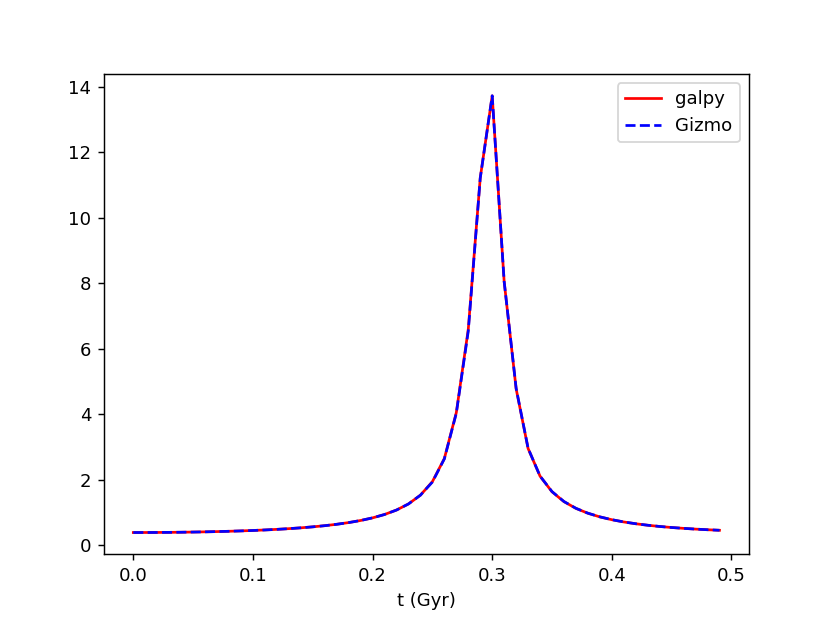

In [33]:
#setup the same analytic disk in galpy
disk_pot = MiyamotoNagaiPotential(amp=5.78*10**10*u.Msun,a=3.*u.kpc,b=0.28*u.kpc,)
disk_pot.turn_physical_off()

ro=8.
galpy_a=[]
gizmo_a=[]

for snap_no in range(len(x4)):
    _R = np.sqrt(x4[snap_no][0]**2 + y4[snap_no][0]**2)

    galpy_aR = evaluateRforces(disk_pot,R=_R/ro,z=z4[snap_no][0]/ro)*bovy_conversion.force_in_kmsMyr(220.,8.)
    galpy_az = evaluatezforces(disk_pot,R=_R/ro,z=z4[snap_no][0]/ro)*bovy_conversion.force_in_kmsMyr(220.,8.)
    galpy_a.append(np.sqrt(galpy_aR**2 + galpy_az**2))
    
    #Gizmo accelerations are in (km/s)^2/kpc = 1.023*(km/s)/Gyr= 0.001*1.023*(km/s/Myr)
    gizmo_aR = np.sqrt(ax4[snap_no][0]**2 + ay4[snap_no][0]**2)*(0.001*1.023) #km/s = 1.023 kpc/Gyr
    gizmo_az = az4[snap_no][0]*(0.001*1.023)
    gizmo_a.append(np.sqrt(gizmo_aR**2 + gizmo_az**2))


plt.figure()
plt.plot(tt4,galpy_a,c='r',label="galpy")
plt.plot(tt4,gizmo_a,c="b",ls="--",label="Gizmo")
plt.legend(loc="upper right")
plt.xlabel("t (Gyr)")
plt.show()

So the units have been implemented properly. 

Next, let's check if the galpy internal units are implemented properly while interpolating snapshot

In [4]:
#convert Gizmo to pynbody and interpolate and use internal galpy units

ff_galpy = Gizmo_to_pynbody(fn="ics/MW_GB_Mres1e6Msun_GD-1_currentPos_velflipped.hdf5",\
                            ptypes=[1],galpy_units=True)

spi_galpy= InterpSnapshotRZPotential(ff_galpy,rgrid=(np.log(0.01),np.log(100./ro),101),\
                                     logR=True,zgrid=(0.,50./ro,101),interpPot=True,zsym=True,numcores=20)


#convert Gizmo to pynbody and interpolate and use physical units
ff_phy = Gizmo_to_pynbody(fn="ics/MW_GB_Mres1e6Msun_GD-1_currentPos_velflipped.hdf5",\
                          ptypes=[1],galpy_units=False)

from galpy.util.bovy_conversion import _G
g= pynbody.array.SimArray(_G/1000.)
g.units= 'kpc Msol**-1 km**2 s**-2 G**-1'
ff_phy._arrays['mass']= ff_phy._arrays['mass']*g

spi_phy= InterpSnapshotRZPotential(ff_phy,rgrid=(np.log(0.01),np.log(100.),101),\
                                   logR=True,zgrid=(0.,50.,101),interpPot=True,zsym=True,numcores=20)




<IPython.core.display.Javascript object>


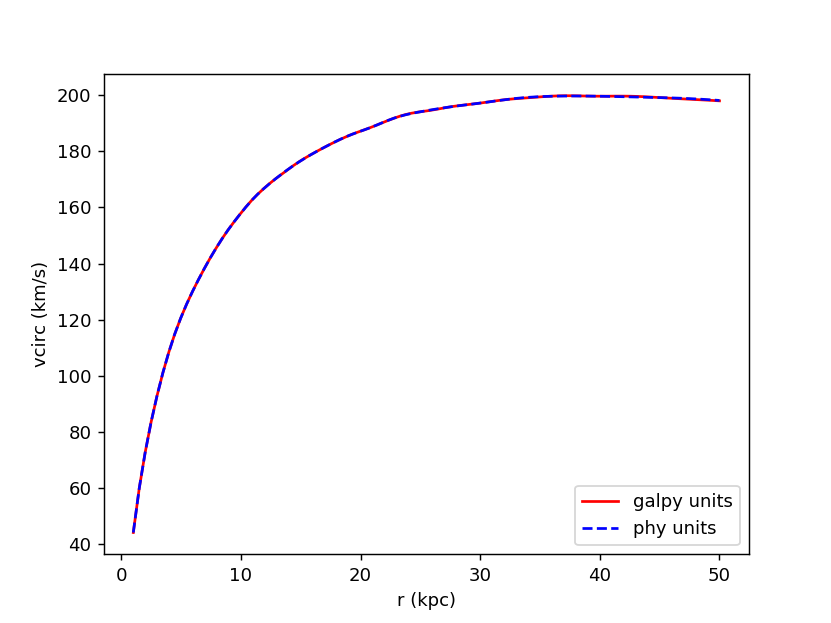

<IPython.core.display.Javascript object>


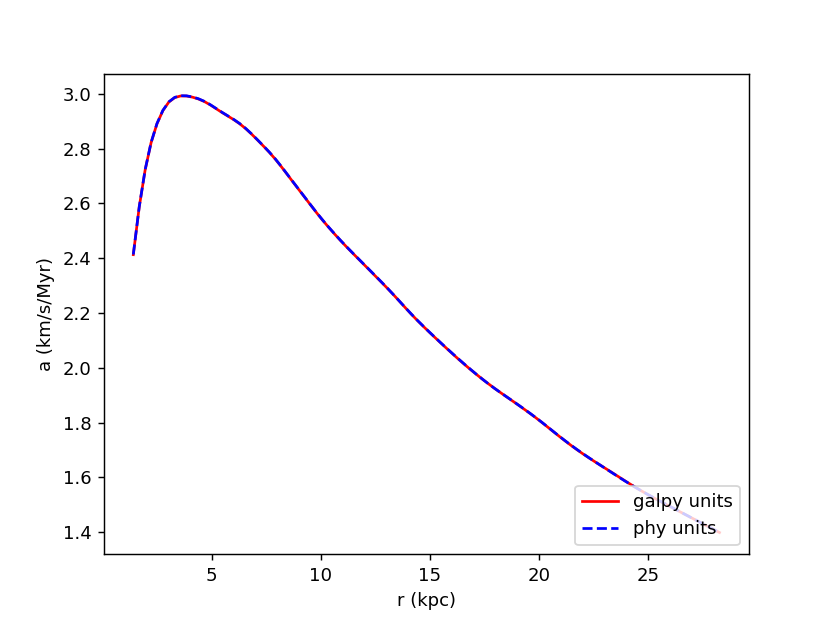

In [34]:
#compare circular velocity and accelertions

rr = np.linspace(1.,50,100)

plt.figure()
plt.plot(rr,vcirc(spi_galpy,rr/8.)*220.,c="r",label="galpy units")
plt.plot(rr,vcirc(spi_phy,rr),c="b",ls="--",label="phy units")
plt.legend(loc="lower right")
plt.xlabel("r (kpc)")
plt.ylabel("vcirc (km/s)")
plt.show()

RR = np.linspace(1.,20,100)
zz = np.linspace(1.,20,100)
_r = np.sqrt(RR**2 + zz**2)

aR_galpy = evaluateRforces(spi_galpy,R=RR/ro,z=zz/ro)*bovy_conversion.force_in_kmsMyr(220.,8.)
az_galpy = evaluatezforces(spi_galpy,R=RR/ro,z=zz/ro)*bovy_conversion.force_in_kmsMyr(220.,8.)

a_galpy = np.sqrt(aR_galpy**2 + az_galpy**2)

aR_gizmo = evaluateRforces(spi_phy,R=RR,z=zz)*(1.023*0.001)
az_gizmo = evaluatezforces(spi_phy,R=RR,z=zz)*(1.023*0.001)

a_gizmo = np.sqrt(aR_gizmo**2 + az_gizmo**2)

#compare accelerations
plt.figure()
plt.plot(_r,a_galpy,c="r",label="galpy units")
plt.plot(_r,a_gizmo,c="b",ls="--",label="phy units")
plt.legend(loc="lower right")
plt.xlabel("r (kpc)")
plt.ylabel("a (km/s/Myr)")
plt.show()



Ok! Looks good.

Finally, let's compare the accelerations computed in Gizmo on a single particle in the presence of the same analytic disk and a live halo with that of the interpolated snapshot of the halo + disk in galpy

In [35]:
dir1 = "ics/single_particle_livehalo_analyticDisk/"

tt4,id4,x4,y4,z4,vx4,vy4,vz4,m4,pot4,ax4,ay4,az4 = extract_data_of_ptype(folder=dir1,ptype=4,nfiles=45,shift_file_ind=0,shift_ID=0,pot_acc=True)

<IPython.core.display.Javascript object>


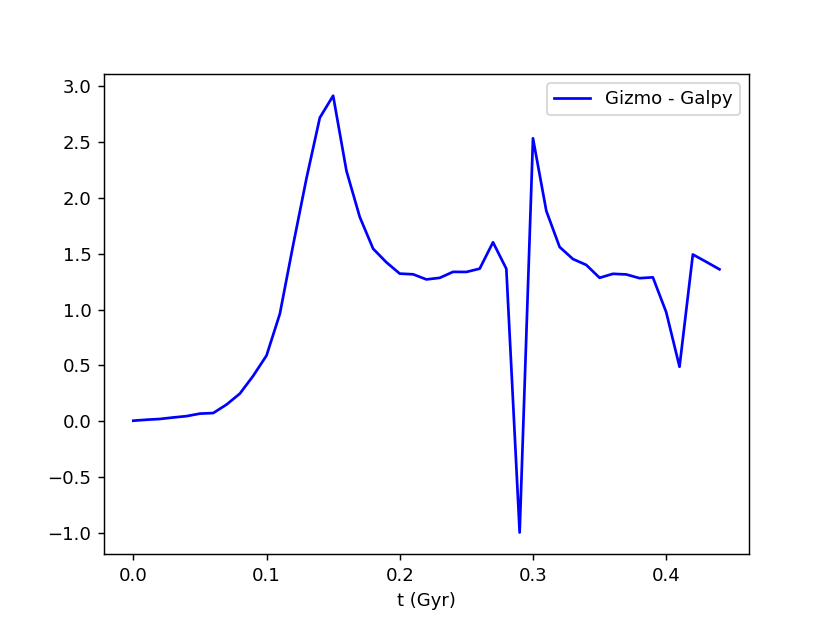

In [38]:
#setup analytic disk
disk_pot = MiyamotoNagaiPotential(amp=5.78*10**10*u.Msun,a=3.*u.kpc,b=0.28*u.kpc,)
disk_pot.turn_physical_off()


ro=8.
galpy_a=[]
gizmo_a=[]

for snap_no in range(len(x4)):
    _R = np.sqrt(x4[snap_no][0]**2 + y4[snap_no][0]**2)

    galpy_aR_disk = evaluateRforces(disk_pot,R=_R/ro,z=z4[snap_no][0]/ro)*bovy_conversion.force_in_kmsMyr(220.,8.)
    galpy_az_disk = evaluatezforces(disk_pot,R=_R/ro,z=z4[snap_no][0]/ro)*bovy_conversion.force_in_kmsMyr(220.,8.)
    
    galpy_aR_halo = evaluateRforces(spi_galpy,R=_R/ro,z=z4[snap_no][0]/ro)*bovy_conversion.force_in_kmsMyr(220.,8.)
    galpy_az_halo = evaluatezforces(spi_galpy,R=_R/ro,z=z4[snap_no][0]/ro)*bovy_conversion.force_in_kmsMyr(220.,8.)

    galpy_aR = galpy_aR_disk + galpy_aR_halo
    galpy_az = galpy_az_disk + galpy_az_halo
       
    galpy_a.append(np.sqrt(galpy_aR**2 + galpy_az**2))
    
    #Gizmo accelerations are in (km/s)^2/kpc = 1.023*(km/s)/Gyr= 0.001*1.023*(km/s/Myr)
    gizmo_aR = np.sqrt(ax4[snap_no][0]**2 + ay4[snap_no][0]**2)*(0.001*1.023) #km/s = 1.023 kpc/Gyr
    gizmo_az = az4[snap_no][0]*(0.001*1.023)
    gizmo_a.append(np.sqrt(gizmo_aR**2 + gizmo_az**2))


plt.figure()
#plt.plot(tt4,galpy_a,c='r',label="galpy")
plt.plot(tt4,np.array(gizmo_a) - np.array(galpy_a),c="b",label="Gizmo - Galpy")
plt.legend(loc="upper right")
plt.xlabel("t (Gyr)")
plt.show()

Let's try with higher resolution 10^5 Msun

In [39]:
#convert Gizmo to pynbody and interpolate and use internal galpy units

ff_galpy = Gizmo_to_pynbody(fn="ics/MW_GB_Mres1e5Msun_GD-1_currentPos_velflipped.hdf5",\
                            ptypes=[1],galpy_units=True)

spi_galpy= InterpSnapshotRZPotential(ff_galpy,rgrid=(np.log(0.01),np.log(100./ro),101),\
                                     logR=True,zgrid=(0.,50./ro,101),interpPot=True,zsym=True,numcores=20)



In [40]:
dir1 = "ics/single_particle_livehalo1e5Msun_analyticDisk/"

tt4,id4,x4,y4,z4,vx4,vy4,vz4,m4,pot4,ax4,ay4,az4 = extract_data_of_ptype(folder=dir1,ptype=4,nfiles=45,shift_file_ind=0,shift_ID=0,pot_acc=True)

<IPython.core.display.Javascript object>


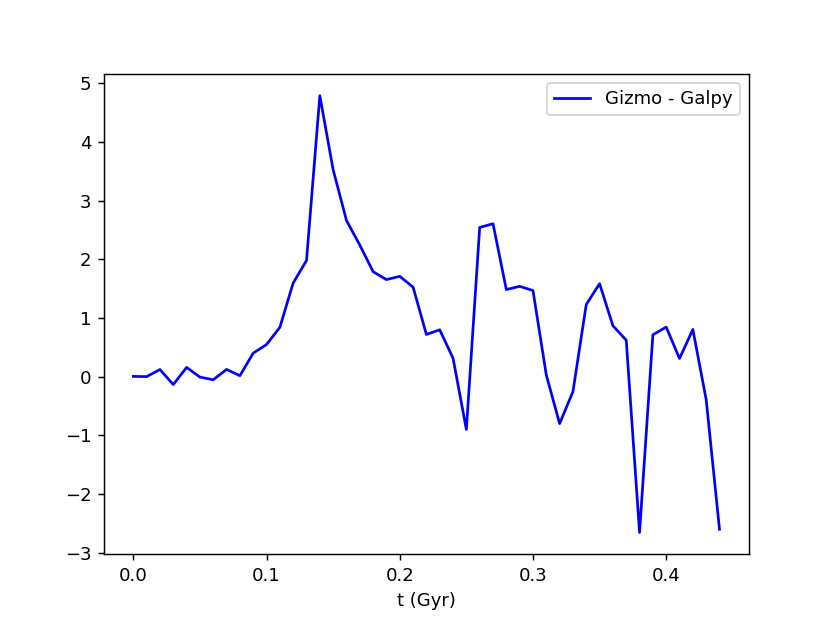

In [41]:
#setup analytic disk
disk_pot = MiyamotoNagaiPotential(amp=5.78*10**10*u.Msun,a=3.*u.kpc,b=0.28*u.kpc,)
disk_pot.turn_physical_off()


ro=8.
galpy_a=[]
gizmo_a=[]

for snap_no in range(len(x4)):
    _R = np.sqrt(x4[snap_no][0]**2 + y4[snap_no][0]**2)

    galpy_aR_disk = evaluateRforces(disk_pot,R=_R/ro,z=z4[snap_no][0]/ro)*bovy_conversion.force_in_kmsMyr(220.,8.)
    galpy_az_disk = evaluatezforces(disk_pot,R=_R/ro,z=z4[snap_no][0]/ro)*bovy_conversion.force_in_kmsMyr(220.,8.)
    
    galpy_aR_halo = evaluateRforces(spi_galpy,R=_R/ro,z=z4[snap_no][0]/ro)*bovy_conversion.force_in_kmsMyr(220.,8.)
    galpy_az_halo = evaluatezforces(spi_galpy,R=_R/ro,z=z4[snap_no][0]/ro)*bovy_conversion.force_in_kmsMyr(220.,8.)

    galpy_aR = galpy_aR_disk + galpy_aR_halo
    galpy_az = galpy_az_disk + galpy_az_halo
       
    galpy_a.append(np.sqrt(galpy_aR**2 + galpy_az**2))
    
    #Gizmo accelerations are in (km/s)^2/kpc = 1.023*(km/s)/Gyr= 0.001*1.023*(km/s/Myr)
    gizmo_aR = np.sqrt(ax4[snap_no][0]**2 + ay4[snap_no][0]**2)*(0.001*1.023) #km/s = 1.023 kpc/Gyr
    gizmo_az = az4[snap_no][0]*(0.001*1.023)
    gizmo_a.append(np.sqrt(gizmo_aR**2 + gizmo_az**2))


plt.figure()
#plt.plot(tt4,galpy_a,c='r',label="galpy")
plt.plot(tt4,np.array(gizmo_a) - np.array(galpy_a),c="b",label="Gizmo - Galpy")
plt.legend(loc="upper right")
plt.xlabel("t (Gyr)")
plt.show()

## Pickle potential

In [10]:
delattr(spi,'_s')
delattr(spi,'_origPot')

save_pickles("Potential_MWHalo_Mres1e6_galpy_units.pkl",spi)

In [11]:
#load the saved pickle file

from galpy.potential import vcirc

with open("Potential_MWHalo_Mres1e6_galpy_units.pkl",'rb') as savefile:
    newspi= pickle.load(savefile,encoding='latin1')

print (vcirc(newspi, 1.),vcirc(spi,1.))

print(evaluateRforces(newspi,R=_R,z=z4[snap_no][0])*bovy_conversion.force_in_kmsMyr(220.,8.))
print(evaluatezforces(newspi,R=_R,z=z4[snap_no][0])*bovy_conversion.force_in_kmsMyr(220.,8.))



0.8232429104886634 0.8232429104886634


PotentialError: "'_Rforce' function not implemented for this potential"